In [185]:
# Imports
import numpy as np
import matplotlib.pylab as plt
dataFolder = '/home/mv/Dropbox/Teaching/ML4Industry/Data/'
np.random.seed(seed=123) # Set the seed for reproducibility

# Finding the signal in a noisy haystack

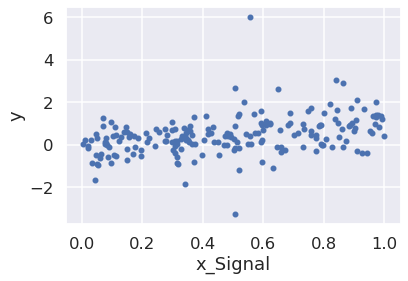

In [199]:
n = 200
pNoise = 20 # How many noise features?
sigmaEps = 0.5
w = np.array([0,1])
xSignal = np.random.uniform(0,1,(n,1))
y = w[0] + w[1]*xSignal+ sigmaEps*np.random.standard_t(df=3, size=(n,1))
xNoise = np.random.normal(size = (n,pNoise))
X = np.hstack([xSignal, xNoise])
X.shape
plt.scatter(xSignal,y, s = 20);
plt.xlabel('x_Signal')
plt.ylabel('y');

### Fitting with least squares, lassoCV and ridgeCV

Lasso regularization: 0.004728554992579641
Ridge regularization: 10.0


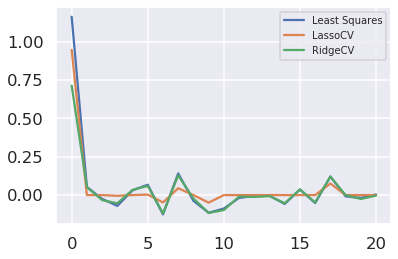

In [219]:
from sklearn import linear_model

# Least squares
regModel = linear_model.LinearRegression()
regModel.fit(X = X, y = np.ravel(y)); 
wLS = regModel.coef_

# Lasso CV
regModel = linear_model.LassoLarsCV(cv = 5)
regModel.fit(X = X, y = np.ravel(y)); 
wLasso = regModel.coef_
print('Lasso regularization: ' + str(regModel.alpha_))

# Ridge CV
regModel = linear_model.RidgeCV(cv = 5)
regModel.fit(X = X, y = np.ravel(y)); 
wRidge = regModel.coef_
print('Ridge regularization: ' + str(regModel.alpha_))

plt.plot(wLS)
plt.plot(wLasso)
plt.plot(wRidge);
plt.legend(labels=['Least Squares', 'LassoCV', 'RidgeCV'], loc = 'upper right', fontsize = 10);
#(X.T@X)[0,0]

## Bias and variance
The idea here is to simulate many datasets, fit a polynomial to each and visualize bias and variance by plotting.\
First, we set up a simulator (data generating process) and take it for a test drive.

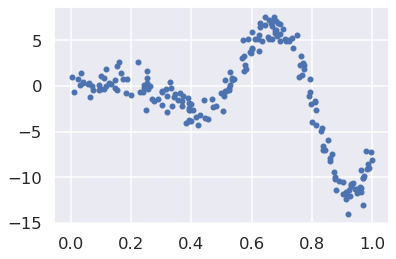

In [221]:
# Define the data generating process: 
# y = w0 + w1*basisFunc(x) + eps, where eps~N(0,sigmaEps²)
# basisFunc can be any function you want
def Simulator(n, basisFunc, w, sigmaEps = 1):
    X = np.random.uniform(0,1,(n,1))
    xBasis = basisFunc(X)
    y = w[0] + w[1]*xBasis + sigmaEps*np.random.normal(size=(n,1))
    return((X,y))

# Simulating some data from the thing
n = 200
sigmaEps = 1
w = np.array([0,5])
basisFunc = lambda x : x*np.sin(12*x)*np.exp(x) # Setting up a basis function using Python's lambda (inline function)
X,y = Simulator(n, basisFunc, w, sigmaEps)
plt.scatter(X,y, s = 20);

Now that we have working simulator, let's simulate nSim datasets from it and fit polynomial of degree polyDegree

Percentage inflation in RMSEtest over RMSEtrain:
7.078747945492782


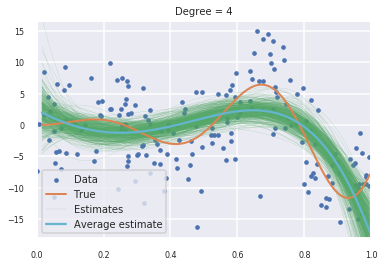

In [271]:
from sklearn import linear_model # submodule with linear models
from sklearn.preprocessing import PolynomialFeatures # Not construct polynomials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # Simple function that computes MSE

regModel = linear_model.LinearRegression()
nSim = 500
n = 200
basisFunc = lambda x : x*np.sin(12*x)*np.exp(x) # Setting up a basis function using Python's lambda (inline function)
sigmaEps = 5
w = np.array([0,5])
polyDegree = 4
testSize = 0.5 # Fraction test data
seeder = 123   # Set the seed for reproducability

xGrid = np.linspace(np.min(X),np.max(X),1000)
xGrid = xGrid.reshape(-1,1) # Convert it to matrix, as required by the predict method.
poly = PolynomialFeatures(degree=polyDegree, include_bias=False)
RMSEtrain = np.zeros(nSim)
RMSEtest = np.zeros(nSim)
meanFit = np.zeros((len(xGrid),1))
X,y = Simulator(n, basisFunc, w, sigmaEps)
data = plt.scatter(X, y, s = 10)

for i in range(nSim):
    X,y = Simulator(n, basisFunc, w, sigmaEps)
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = testSize, random_state = seeder)
    xBasisTrain = poly.fit_transform(xTrain)
    regModel.fit(X = xBasisTrain, y = yTrain)
    
    # RMSE training
    yPredTrain = regModel.predict(X = xBasisTrain)
    RMSEtrain[i] = np.sqrt(mean_squared_error(yTrain, yPredTrain))

    # Plotting the fit
    xGridBasis = poly.fit_transform(xGrid)
    yFit = regModel.predict(X = xGridBasis)
    fitLine, = plt.plot(xGrid, yFit, 'C2', linewidth = 0.1);
    meanFit = meanFit + yFit
  
    # Prediction on test data
    xBasisTest = poly.fit_transform(xTest)
    yPredTest = regModel.predict(X = xBasisTest)
    RMSEtest[i] = np.sqrt(mean_squared_error(yTest, yPredTest))
    
# Plot the true function     
trueMean = w[0] + w[1]*basisFunc(xGrid)
trueLine, = plt.plot(xGrid, trueMean, 'C1', linewidth = 2)

# Plot the sample mean of the estimates
meanFit = meanFit/nSim # Mean fit over all datasets
meanLine, = plt.plot(xGrid, meanFit, 'C9');

plt.title('Degree = '+str(polyDegree), fontsize=10);
plt.ylim(np.min(y), np.max(y));
plt.xlim(0,1);
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.legend((data, trueLine, fitLine, meanLine),('Data','True','Estimates','Average estimate'), loc = 'lower left', fontsize = 10)

print('Percentage inflation in RMSEtest over RMSEtrain:')
print(np.mean((RMSEtest-RMSEtrain)/RMSEtrain)*100)

plt.savefig('polyRepeatSample.png')